# Spam Email Detection using Neural Networks

## Libraries importation

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

from collections import Counter
from dbrepo.RestClient import RestClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout

## Input data loading

In this part we will load the data from DBREPO, using the predefined sets (train, test, valid). 

For more information on how the subsets were created see the `data_preprocessing.ipynb` notebook or the [spam_mail_detector](https://test.dbrepo.tuwien.ac.at/database/7105b5ed-3020-42ad-8f67-f670c2f6fa18/info) database on DBREPO.


In [30]:
# Initialize the RestClient
dbrepo_client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at")

# Database and subset IDs
database_id = "7105b5ed-3020-42ad-8f67-f670c2f6fa18"
train_subset_id = "730fea6e-187a-11f0-b919-f68d2490d0da"
test_subset_id = "3c48ba6e-187b-11f0-a3a8-2ebef9ba1aed"
val_subset_id = "08c5056c-187b-11f0-b919-f68d2490d0da"

# Load datasets from DBRepo
train_set = dbrepo_client.get_subset_data(database_id=database_id, subset_id=train_subset_id, size=4000)
test_set = dbrepo_client.get_subset_data(database_id=database_id, subset_id=test_subset_id, size=1200)
validation_set = dbrepo_client.get_subset_data(database_id=database_id, subset_id=val_subset_id, size=1000)

# The label_num column is saved as a boolean in DBRepo, but this converts label_num to a string with "true" or "false" 
# To be more practical, we convert it to 1 or 0 respectively
train_set["label_num"] = train_set["label_num"].apply(lambda x: 1 if x == "true" else 0)
test_set["label_num"] = test_set["label_num"].apply(lambda x: 1 if x == "true" else 0)
validation_set["label_num"] = validation_set["label_num"].apply(lambda x: 1 if x == "true" else 0)

# Get values from class
y_train = train_set["label_num"].values
y_test = test_set["label_num"].values
y_val = validation_set["label_num"].values

## Embeddings generation

Here we will vectorize the preprocessed emails (`lemmatized_text`) using `TfidfVectorizer` from `sklearn`.

In [31]:
# Initialize vectorizer
vectorizer = TfidfVectorizer()

# Fit vectorizer on training set
vectorizer.fit(train_set["lemmatized_text"])

def generate_embeddings(df):
    embeddings = vectorizer.transform(df["lemmatized_text"])
    return embeddings.toarray()

embeddings_train = generate_embeddings(train_set)
embeddings_test = generate_embeddings(test_set)
embeddings_val = generate_embeddings(validation_set)

## Model training

Here we define the model architecture and train the model using the training set. In this case we will use a simple feedforward neural network with two hidden layers of 15 and 10 neurons, respectively. The activation function used is `relu` and the output layer uses `sigmoid` activation function. 

Then the model will be compiled using `binary_crossentropy` as loss function and `adam` as optimizer. The model will be trained for 10 epochs with a batch size of 32. And finally, save the model to a file in the `output` directory.

In [32]:
# Define model architecture
nn_model = Sequential([
    Dense(15, activation='relu', input_dim=embeddings_train.shape[1]), # Input layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(10, activation='relu'),  # Intermediate layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(5, activation='relu'),  # Intermediate layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

/Users/saito/Desktop/TU WIEN - SS 2025/Data stewardship/Ex2/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

nn_model.fit(embeddings_train, y_train, validation_data=(embeddings_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7142 - loss: 0.6782 - precision: 0.5116 - recall: 0.2003 - val_accuracy: 0.9708 - val_loss: 0.4891 - val_precision: 0.9141 - val_recall: 0.9933
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.3937 - precision: 0.8936 - recall: 0.9771 - val_accuracy: 0.9903 - val_loss: 0.0938 - val_precision: 0.9801 - val_recall: 0.9867
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0929 - precision: 0.9700 - recall: 0.9866 - val_accuracy: 0.9903 - val_loss: 0.0393 - val_precision: 0.9866 - val_recall: 0.9800
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0394 - precision: 0.9891 - recall: 0.9961 - val_accuracy: 0.9903 - val_loss: 0.0284 - val_precision: 0.9866 - val_recall: 0.9800
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0221 - precision: 0.9943 - recall: 0.9926 - val_accuracy: 0.9903 - val_loss: 0.

In [34]:
# Save model
nn_model.save("output/spam_nn_model_v1.h5")

2025-04-23 16:47:07,645 absl         WARNING You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


## Model evaluation

In this part a pretrained model will be loaded from the `output` directory and evaluated using the test set. The evaluation will be done using accuracy, precision, recall and F1 score.

In [35]:
# Load the model
nn_model = load_model("output/spam_nn_model_v1.h5")

2025-04-23 16:47:07,672 absl         WARNING Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [36]:
# Predict the labels
y_pred_probs = nn_model.predict(embeddings_test)

# Convert probabilities of predictions to classes
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Save predicted labels is test_set
test_set["predicted_label"] = y_pred_classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [37]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_classes)

print(cm)

Accuracy: 0.9865
Precision: 0.9855
Recall: 0.9644
F1 Score: 0.9748
[[754   4]
 [ 10 271]]


## Result analysis

Here we will analyze the results, in order to find some patterns in spam emails.

In [38]:
# Get all spam predicted correctly
predicted_spam = test_set[(test_set["label_num"] == 1) & (test_set["predicted_label"] == 1)]

# Combine all messages as a big string
all_text = " ".join(predicted_spam["lemmatized_text"].astype(str).tolist())

# Split text by words
words = all_text.split()

In [ ]:
# Function to remove words from custom_stopwords (mainly html tags)
def is_valid_word(word, custom_stopwords):
    word = word.strip().lower()
    return (
        word.isalpha()              
        and len(word) > 2 
        and word not in custom_stopwords
    )

In [40]:
# Count words
word_counts = Counter(words)

# Remove non-informative words (numbers, html tags, etc)
custom_stopwords = ["subject", "height", "width", "align", "tr", "font", "src", "href", "border", "center"]

filtered_word_counts = Counter({
    word: count for word, count in word_counts.items()
    if is_valid_word(word, custom_stopwords)
})

# Get top k most common words
most_common_words = filtered_word_counts.most_common(10)

most_common_words

[('http', 292),
 ('com', 148),
 ('get', 128),
 ('company', 109),
 ('price', 106),
 ('time', 92),
 ('new', 83),
 ('stock', 83),
 ('please', 79),
 ('good', 77)]

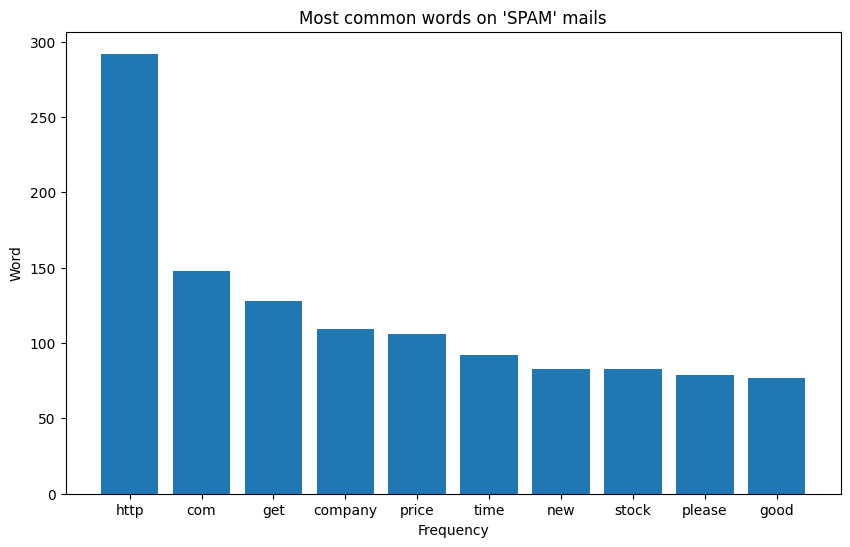

In [41]:
words_df = pd.DataFrame(most_common_words, columns=["word", "count"])


plt.figure(figsize=(10, 6))
plt.bar(words_df["word"], words_df["count"])
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most common words on 'SPAM' mails")
plt.gca()
plt.show()

In this plot we can observe the top 10 most common words in `spam` emails. The words are sorted by their frequency in the spam emails. 

As we can see `http` and `com` are the most common words in spam emails. This is a clear indication that spam emails are usually related to some kind of advertisement or phishing due to the constant presence of links in the emails.


## Save results (locally)

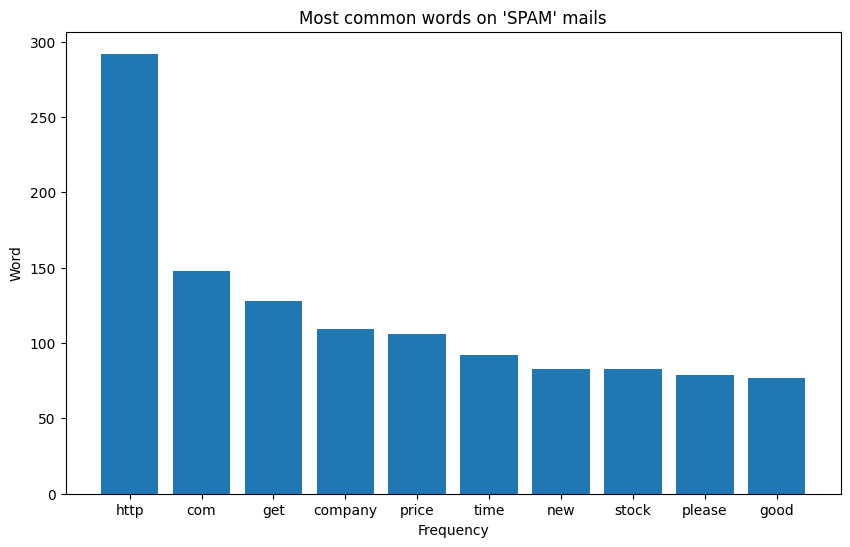

In [ ]:
# Save the plot of the top 10 most common words on spam mails in the output folder
plt.figure(figsize=(10, 6))
plt.bar(words_df["word"], words_df["count"])
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most common words on 'SPAM' mails")
plt.gca()
plt.savefig("output/top10_spam_tokens.png")

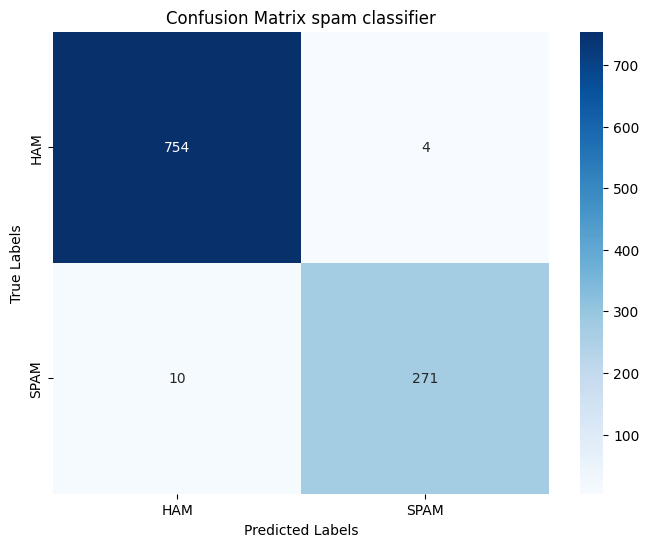

In [ ]:
# Save a confusion matrix plot in the output folder
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["HAM", "SPAM"], yticklabels=["HAM", "SPAM"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix spam classifier")
plt.savefig("output/confusion_matrix.png")
plt.show()


In [56]:
# Save model
nn_model.save("output/spam_nn_model_v1.h5")

# Save metrics
with open("output/evaluation_metrics.txt", "w") as f:
    f.write("Spam - Ham Classifier Metrics\n")
    f.write("====================================\n")
    f.write(f"Database ID: {database_id}\n")
    f.write(f"Train Subset ID: {train_subset_id}\n")
    f.write(f"Test Subset ID: {test_subset_id}\n")
    f.write(f"Validation Subset ID: {val_subset_id}\n")
    f.write("====================================\n")
    f.write(f"Number of training samples: {len(train_set)}\n")
    f.write(f"Number of test samples: {len(test_set)}\n")
    f.write(f"Number of validation samples: {len(validation_set)}\n")
    f.write("====================================\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}")

# Save predictions
test_set[["experiment_id", "predicted_label", "label_num"]].to_csv("output/test_predictions.csv", index=False)


2025-04-23 16:51:40,866 absl         WARNING You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


## Upload results to TUWRD

In [1]:
access_token = 'your_access_token_here'
record_id = "0e1sf-saz86"
base_url = f"https://test.researchdata.tuwien.ac.at/api/records/{record_id}/draft"

### Initialize File Upload

In [4]:
endpoint_upload = f"{base_url}/files"

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json"
}

data = [
  {"key": "figure.png"},
  {"key": "article.pdf"},
  {"key": "data.zip"}
]

response = requests.post(endpoint_upload, json=data, headers=headers)
print(response.json())

{'status': 404, 'message': 'Not found.'}


### Upload File Content

In [59]:
file_names = [
    "confusion_matrix.png",
    "top10_spam_tokens.png",
    "spam_nn_model_v1.h5",
    "evaluation_metrics.txt",
    "test_predictions.csv"
]

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/octet-stream"
}


for file_name in file_names:
        endpoint_content = f"{base_url}/files/{file_name}/content"
        with open(f"output/{file_name}", "rb") as f:
            response = requests.put(endpoint_content, data=f, headers=headers)

print(response.json())

{'status': 403, 'message': 'Permission denied.'}


### Commit Draft File Upload

In [61]:
for file_name in file_names:
        endpoint_commit = f"{base_url}/files/{file_name}/commit"
        with open(f"output/{file_name}", "rb") as f:
            response = requests.post(endpoint_content, data=f, headers=headers)